# **WORD2VEC & PMI**

Summary:


1.   Import *narco_schedule*
2.   Import Word2Vec and Train Models
3.   Most Similar Terms




---

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import sys
sys.path.append('/content/drive/My Drive/Università/inforet_prj/')

In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import pickle
import spacy
import string
import seaborn as sns; sns.set()
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

In [8]:
from nltk import ngrams
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

## **1. Import narco_schedule**

In [24]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_schedule.pkl", "rb") as f:
  narco_schedule = pickle.load(f)

In [108]:
narco_schedule = narco_schedule.loc[(narco_schedule.schedule != "0") ] #& (narco_schedule.schedule != "narco_3")
narco_schedule

,schedule,lemmatized
1,narco_1,issue consolidated appeal constitutionality en...
2,narco_2,indict count murder aggravate criminal sexual ...
3,narco_3,appeal jury verdict find sexually violent pers...
4,narco_4,charge information count bribery count possess...


In [ ]:
narco_schedule_1 = narco_schedule.loc[(narco_schedule.schedule == "narco_1") ] 
narco_schedule_1

,schedule,lemmatized
1,narco_1,issue consolidated appeal constitutionality en...


In [ ]:
narco_schedule_2 = narco_schedule.loc[(narco_schedule.schedule == "narco_2") ] 
narco_schedule_2

,schedule,lemmatized
2,narco_2,indict count murder aggravate criminal sexual ...


## **2. Import Word2Vec and Train Models**

In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-09-21 09:22:51--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.27.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.27.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  85.1MB/s    in 23s     

2021-09-21 09:23:14 (68.5 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
word_vectors = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [ ]:
n = 5
sequences_1 = {}
for sched, x in tqdm(zip(narco_schedule_1.schedule, narco_schedule_1.lemmatized), total=narco_schedule_1.shape[0]):
    penta_gram = ngrams(x.split(), n)

    sequences_1[sched] = ([[y[0], y[1], y[2], y[3], y[4]] for y in penta_gram])

100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


In [ ]:
sequences_2 = {}
for sched, x in tqdm(zip(narco_schedule_2.schedule, narco_schedule_2.lemmatized), total=narco_schedule_2.shape[0]):
    penta_gram = ngrams(x.split(), n)

    sequences_2[sched] = ([[y[0], y[1], y[2], y[3], y[4]] for y in penta_gram])

100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


---

In [ ]:
models_1 = {}
for schedule, sequence in sequences_1.items():
    models_1[schedule] = Word2Vec(sequences_1[schedule], min_count=10)

In [ ]:
models_2 = {}
for schedule, sequence in sequences_2.items():
    models_2[schedule] = Word2Vec(sequences_2[schedule], min_count=10)

---

## **3. Most Similar Terms**

### *3.1 Positive Similarity*

In [ ]:
drug = 'drug'
narcotic = 'narcotic'
crime = 'crime'
defendant = 'defendant'
addiction = 'addiction'

In [ ]:
for genre, model in models_1.items():
    print(genre, drug, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(positive=drug)][:7])
    print(genre, narcotic, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(positive=narcotic)][:7])
    print(genre, crime, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(positive=crime)][:7])
    print(genre, defendant, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(positive=defendant)][:7])
    print(genre, addiction, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(positive=addiction)][:7])

narco_1 drug [('narcotic', 0.62), ('heroin', 0.61), ('dope', 0.59), ('junk', 0.52), ('cannabis', 0.5), ('marijuana', 0.48), ('profiteer', 0.45)]
narco_1 narcotic [('heroin', 0.73), ('drug', 0.62), ('dope', 0.54), ('buyer', 0.53), ('contraband', 0.48), ('illicit', 0.46), ('cannabis', 0.46)]
narco_1 crime [('offense', 0.77), ('lure', 0.49), ('perjury', 0.48), ('felony', 0.44), ('murder', 0.44), ('venture', 0.43), ('burglary', 0.43)]
narco_1 defendant [('petitioner', 0.62), ('have', 0.53), ('respondent', 0.43), ('codefendant', 0.42), ('accuse', 0.41), ('deny', 0.41), ('time', 0.41)]
narco_1 addiction [('addict', 0.64), ('usage', 0.62), ('habit', 0.59), ('user', 0.55), ('ingest', 0.53), ('rehabilitation', 0.49), ('addicted', 0.49)]


In [ ]:
for genre, model in models_2.items():
    print(genre,  drug, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(positive=drug)][:7])
    print(genre, narcotic, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(positive=narcotic)][:7])
    print(genre, crime, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(positive=crime)][:7])    
    print(genre, defendant, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(positive=defendant)][:7])       
    print(genre, addiction, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(positive=addiction)][:7])    

narco_2 drug [('narcotic', 0.8), ('cocaine', 0.71), ('consummate', 0.5), ('profit', 0.48), ('dope', 0.48), ('buying', 0.47), ('occasional', 0.47)]
narco_2 narcotic [('drug', 0.8), ('cocaine', 0.66), ('contraband', 0.5), ('substance', 0.5), ('middleman', 0.47), ('paraphernalia', 0.46), ('prostitution', 0.46)]
narco_2 crime [('offense', 0.71), ('peijury', 0.52), ('homicide', 0.48), ('murder', 0.48), ('killing', 0.45), ('shooting', 0.42), ('arson', 0.42)]
narco_2 defendant [('codefendant', 0.5), ('petitioner', 0.49), ('have', 0.44), ('trial', 0.4), ('respondent', 0.4), ('claimant', 0.4), ('victim', 0.4)]
narco_2 addiction [('abuser', 0.6), ('addict', 0.59), ('drunkenness', 0.59), ('usage', 0.58), ('alcoholism', 0.57), ('psychotropic', 0.54), ('antidepressant', 0.53)]


In [ ]:
lista = []
for genre, model in models_2.items():
    for x in model.wv.most_similar(positive='drug')[:7]:
        lista.append(x[0])

In [ ]:
def most_similar_list(model_, word, n):
    lista = []
    for genre, model in model_.items():
        for x in model.wv.most_similar(positive=word)[:n]:
            lista.append(x[0])
    return lista

In [ ]:
lista_drug_1 = most_similar_list(models_1, 'drug', 10)
lista_narcotic_1 = most_similar_list(models_1, 'narcotic', 10)
lista_crime_1 =  most_similar_list(models_1, 'crime', 10)
lista_defendant_1 =  most_similar_list(models_1, 'defendant', 10)
lista_addiction_1 =  most_similar_list(models_1, 'addiction', 10)
lista_drug_2 = most_similar_list(models_2, 'drug', 10)
lista_narcotic_2 = most_similar_list(models_2, 'narcotic', 10)
lista_crime_2 =  most_similar_list(models_2, 'crime', 10)
lista_defendant_2 =  most_similar_list(models_2, 'defendant', 10)
lista_addiction_2 =  most_similar_list(models_2, 'addiction', 10)

In [ ]:
similar_compare_drug = pd.concat([pd.DataFrame(lista_drug_1, columns=['drug_1']),  pd.DataFrame(lista_drug_2, columns=['drug_2'])], axis=1)
similar_compare_narcotic = pd.concat([pd.DataFrame(lista_narcotic_1, columns=['narcotic_1']),  pd.DataFrame(lista_narcotic_2, columns=['narcotic_2'])], axis=1)
similar_compare_crime = pd.concat([pd.DataFrame(lista_crime_1, columns=['crime_1']),  pd.DataFrame(lista_crime_2, columns=['crime_2'])], axis=1)
similar_compare_defendant = pd.concat([pd.DataFrame(lista_defendant_1, columns=['defendant_1']),  pd.DataFrame(lista_defendant_2, columns=['defendant_2'])], axis=1)
similar_compare_addiction = pd.concat([pd.DataFrame(lista_addiction_1, columns=['addiction_1']),  pd.DataFrame(lista_addiction_2, columns=['addiction_2'])], axis=1)

In [ ]:
pd.concat([similar_compare_drug, similar_compare_narcotic, similar_compare_crime, similar_compare_defendant, similar_compare_addiction ], axis=1)

,drug_1,drug_2,narcotic_1,narcotic_2,crime_1,crime_2,defendant_1,defendant_2,addiction_1,addiction_2
0,narcotic,narcotic,heroin,drug,offense,offense,petitioner,codefendant,addict,abuser
1,heroin,cocaine,drug,cocaine,lure,peijury,have,petitioner,usage,addict
2,dope,consummate,dope,contraband,perjury,homicide,respondent,have,habit,drunkenness
3,junk,profit,buyer,substance,felony,murder,codefendant,trial,user,usage
4,cannabis,dope,contraband,middleman,murder,killing,accuse,respondent,ingest,alcoholism
5,marijuana,buying,illicit,paraphernalia,venture,shooting,deny,claimant,rehabilitation,psychotropic
6,profiteer,occasional,cannabis,prostitution,burglary,arson,time,victim,addicted,antidepressant
7,dispense,commodity,junk,methamphetamine,homicide,perjury,defense,defense,addictive,abstain
8,buyer,substance,informer,network,robbery,lence,trial,man,dependency,dependency
9,substance,setup,consummate,casual,actor,burglary,burglary,ant,pusher,intoxication


In [ ]:
lista_drug = most_similar_list(models_2, 'drug', 10)
lista_narcotic = most_similar_list(models_2, 'narcotic', 10)
most_similar_df = pd.concat([pd.DataFrame(lista_drug, columns=['drug']),  pd.DataFrame(lista_narcotic, columns=['narcotic'])], axis=1)
most_similar_df

,drug,narcotic
0,narcotic,drug
1,cocaine,cocaine
2,consummate,contraband
3,profit,substance
4,dope,middleman
5,buying,paraphernalia
6,occasional,prostitution
7,commodity,methamphetamine
8,substance,network
9,setup,casual


In [ ]:
def most_similar_list_value(model_, word, n):
    lista = []
    for genre, model in model_.items():
        for x in model.wv.most_similar(positive=word)[:n]:
            lista.append([x[0], round(x[1], 2)])
    return lista

In [ ]:
lista_drug_v = most_similar_list_value(models_2, 'drug', 10)
lista_narcotic_v = most_similar_list_value(models_2, 'narcotic', 10)
most_similar_value_df = pd.concat([pd.DataFrame(lista_drug_v, columns=['drug', 'value']),  pd.DataFrame(lista_narcotic_v, columns=['narcotic', 'value'])], axis=1)
most_similar_value_df

,drug,value,narcotic,value
0,narcotic,0.80,drug,0.80
1,cocaine,0.71,cocaine,0.66
2,consummate,0.50,contraband,0.50
3,profit,0.48,substance,0.50
4,dope,0.48,middleman,0.47
5,buying,0.47,paraphernalia,0.46
6,occasional,0.47,prostitution,0.46
7,commodity,0.46,methamphetamine,0.45
8,substance,0.46,network,0.45
9,setup,0.45,casual,0.44


---

### *3.2 Negative Similarity*

In [ ]:
for genre, model in models_1.items():
    print(genre, drug, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(negative=['drug'])][:7])
    print(genre, narcotic, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(negative=['narcotic'])][:7])
    print(genre, crime, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(negative=['crime'])][:7])
    print(genre, defendant, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(negative=['defendant'])][:7])
    print(genre, addiction, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(negative=['addiction'])][:7])

narco_1 drug [('bone', 0.32), ('advocate', 0.31), ('forceful', 0.3), ('compatible', 0.29), ('bloody', 0.29), ('realm', 0.28), ('movant', 0.28)]
narco_1 narcotic [('genital', 0.34), ('censor', 0.32), ('exhibition', 0.31), ('advocacy', 0.31), ('farce', 0.3), ('ray', 0.3), ('albeit', 0.29)]
narco_1 crime [('proposal', 0.38), ('molding', 0.36), ('cup', 0.36), ('pediatrician', 0.35), ('breast', 0.35), ('instal', 0.35), ('shake', 0.34)]
narco_1 defendant [('regulatory', 0.42), ('decency', 0.41), ('industry', 0.4), ('modern', 0.39), ('ideal', 0.39), ('specification', 0.39), ('rigidity', 0.37)]
narco_1 addiction [('shade', 0.37), ('steering', 0.35), ('cushion', 0.34), ('dashboard', 0.34), ('wheel', 0.33), ('unlocked', 0.32), ('smooth', 0.32)]


In [ ]:
for genre, model in models_2.items():
    print(genre, drug, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(negative=['word'])][:7])
    print(genre, narcotic, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(negative=['narcotic'])][:7])
    print(genre, crime, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(negative=['crime'])][:7])
    print(genre, defendant, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(negative=['defendant'])][:7])
    print(genre, addiction, [(x[0], round(x[1], 2)) for x in model.wv.most_similar(negative=['addiction'])][:7])

narco_2 drug [('relitigation', 0.33), ('ar', 0.29), ('dence', 0.29), ('social', 0.29), ('spine', 0.28), ('chairman', 0.28), ('doctorate', 0.27)]
narco_2 narcotic [('conformity', 0.38), ('cessation', 0.38), ('posture', 0.36), ('depress', 0.36), ('revive', 0.36), ('survive', 0.34), ('dignity', 0.34)]
narco_2 crime [('roll', 0.38), ('sick', 0.37), ('brake', 0.35), ('uncharted', 0.35), ('noncompliant', 0.32), ('focused', 0.32), ('lip', 0.31)]
narco_2 defendant [('evaporate', 0.51), ('numeral', 0.47), ('airway', 0.45), ('ventilate', 0.43), ('physiological', 0.42), ('ventilation', 0.41), ('strive', 0.41)]
narco_2 addiction [('hat', 0.44), ('vinyl', 0.41), ('ponytail', 0.4), ('sweatshirt', 0.38), ('beard', 0.38), ('shirt', 0.38), ('rust', 0.38)]


---

## **4. Plotting Similarity**

In [ ]:
## SCHEDULE 1
words = ["cannabis",  "marijuana",  "heroin", "drug", "narcotic", "crime"]
similarities = np.zeros((len(words), len(words)), dtype=np.float_)
for idx1, word1 in enumerate(words):
    for idx2, word2 in enumerate(words):
        # note KeyError is possible if word doesn't exist
        sim = models_1['narco_1'].wv.similarity(word1, word2)
        similarities[idx1, idx2] = sim
        
df = pd.DataFrame.from_records(similarities, columns=words)
df.index = words

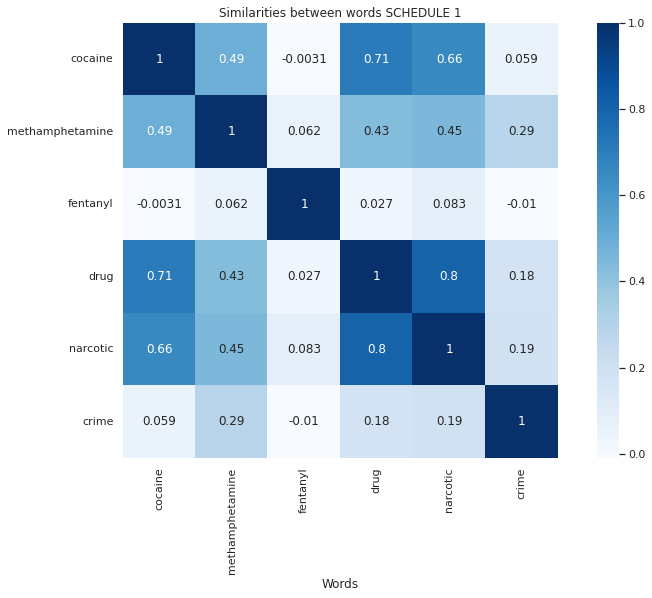

In [ ]:
f, ax=plt.subplots(1, 1, figsize=(14,8))
cmap = plt.cm.Blues
#mask = np.zeros_like(df)
#mask[np.triu_indices_from(mask)] = True
sns.heatmap(df, cmap=cmap, square=True,annot=True, ax=ax)
#_=plt.yticks(rotation=90)
plt.xlabel('Words')
#_=plt.xticks(rotation=45)
_=plt.title("Similarities between words SCHEDULE 1")

---

In [ ]:
## SCHEDULE 2
words = ["cocaine", "methamphetamine", "fentanyl", "drug", "narcotic", "crime"]
similarities = np.zeros((len(words), len(words)), dtype=np.float_)
for idx1, word1 in enumerate(words):
    for idx2, word2 in enumerate(words):
        # note KeyError is possible if word doesn't exist
        sim = models_2['narco_2'].wv.similarity(word1, word2)
        similarities[idx1, idx2] = sim
        
df = pd.DataFrame.from_records(similarities, columns=words)
df.index = words

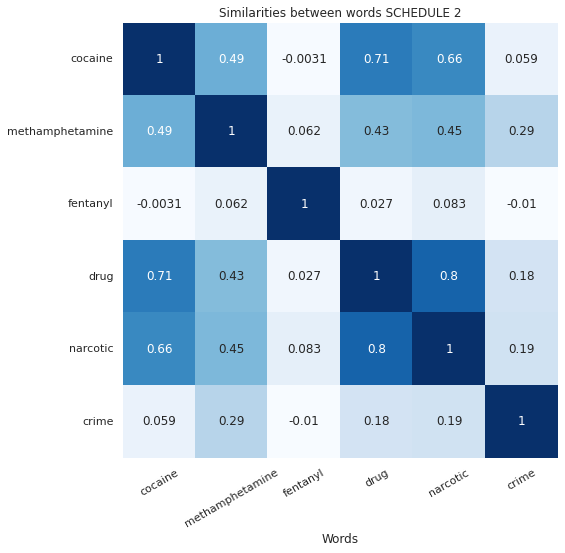

In [ ]:
f, ax=plt.subplots(1, 1, figsize=(14,8))
cmap = plt.cm.Blues
axr = sns.heatmap(df, cmap=cmap, square=True ,annot=True, ax=ax, cbar=False)
plt.xlabel('Words')
_=plt.xticks(rotation=30)
_=plt.title("Similarities between words SCHEDULE 2")

In [ ]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [ ]:
['relitigation','ar', 'dence','social','spine','chairman','doctorate','conformity','cessation','posture','depress','revive','survive','dignity','roll','sick', 'brake','uncharted','noncompliant', 'focused', 'lip', 'evaporate','numeral',  'airway', 'ventilate','physiological', 'ventilation', 'strive', 
'hat', 'vinyl', 'ponytail', 'sweatshirt', 'beard','shirt', 'rust']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


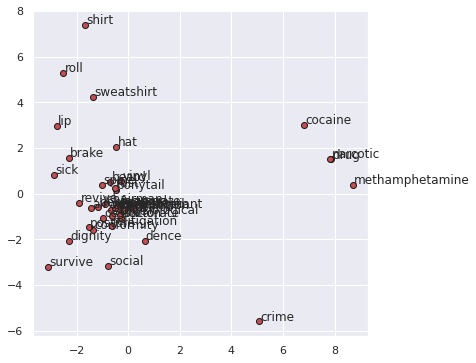

In [ ]:
display_pca_scatterplot(models_2['narco_2'], 
                        ["cocaine", "methamphetamine", "fentanyl", "drug", "narcotic", "crime", 'relitigation','ar', 'dence','social','spine','chairman','doctorate','conformity','cessation','posture','depress','revive','survive','dignity','roll','sick', 'brake','uncharted','noncompliant', 'focused', 'lip', 'evaporate','numeral',  'airway', 'ventilate','physiological', 'ventilation', 'strive', 
'hat', 'vinyl', 'ponytail', 'sweatshirt', 'beard','shirt', 'rust'])

In [ ]:
for genre, model in models_1.items():
    print(genre, model.wv.most_similar(positive=['narcotic'], negative=['man'])[0][0])

narco_1 heroin


In [ ]:
for genre, model in models_2.items():
    print(genre, model.wv.most_similar(positive=['narcotic'], negative=['man'])[0][0])

narco_2 drug


---

In [ ]:
for genre, model in models_1.items():
    print(genre, model.wv.most_similar(positive=['defendant', 'trial'], 
                                    negative=['man'])[0][0])

narco_1 defense


In [ ]:
for genre, model in models_1.items():
    print(genre, model.wv.most_similar(positive=['defendant', 'trial'], 
                                    negative=['man'])[0][0])

narco_1 defense


## **5. PMI**

In [ ]:
narco_1_pmi_nlp = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_1_pmi_nlp.csv", sep="|" , names=["sentences_lemma"] )
narco_1_pmi = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_1_pmi.csv", sep="|" )

In [ ]:
narco_1_pmi = pd.concat([narco_1_pmi, narco_1_pmi_nlp], axis=1)
narco_1_pmi = narco_1_pmi.drop(['type','text','author', 'sentences_joined'], axis = 1)

In [ ]:
narco_1_pmi =narco_1_pmi[:2]
narco_1_pmi.sentences_lemma[0]

"['issue these consolidated appeal be constitutionality enact', 'plaintiff each challenge violative single subject rule contain article section', 'each rule that be unconstitutional ground order that appellant be enjoin from enforce any provision', 'affirm reverse court judgment', 'single subject rule concern method which legislation be enact', 'begin review procedural history substance', 'be introduce', 'that time bill be entitle an relation prisoner reimbursement expense incur their incarceration amend name bill be page long address specific topic', 'pass bill amendment', 'reach amendment through be place bill', 'amendment address array different subject include inter alla expulsion school student bring weapon school increase penalty possession cannabis provide privatization some service', 'retitle bill an relation crime these amendment pass be send', 'could agree which amendment bill should stand', 'result conference committee be form', 'conference committee change title bill replac

In [ ]:
## https://shravan-kuchkula.github.io/nlp/document_similarity/#normalize-the-corpus-of-documents

In [ ]:
## PMI CO-OCCURRENCE
from collections import defaultdict
def co_occurrence(sentences, window_size):
    d = defaultdict(int)
    vocab = set()
    for text in sentences:
        # preprocessing (use tokenizer instead)
        text = text.lower().split()
        # iterate over sentences
        for i in range(len(text)):
            token = text[i]
            vocab.add(token)  # add to vocab
            next_token = text[i+1 : i+1+window_size]
            for t in next_token:
                key = tuple( sorted([t, token]) )
                d[key] += 12

    # formulate the dictionary into dataframe
    vocab = sorted(vocab) # sort vocab
    df = pd.DataFrame(data=np.zeros((len(vocab), len(vocab)), dtype=np.int16),
                      index=vocab,
                      columns=vocab)
    for key, value in d.items():
        df.at[key[0], key[1]] = value
        df.at[key[1], key[0]] = value
    return df

In [ ]:
co_matrix = co_occurrence(narco_1_pmi.sentences_lemma, 2)

In [ ]:
def pmi(df, positive=True):
    col_totals = df.sum(axis=0)
    total = col_totals.sum()
    row_totals = df.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    df = df / expected
    # Silence distracting warnings about log(0):
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  # log(0) = 0
    if positive:
        df[df < 0] = 0.0
    return df

In [ ]:
co_matrix = pmi(co_matrix, positive=True)
co_matrix

,"'',",''],'above,'accept,'accuse,'act,'action,'add,'addition,'address,'admit,'affirm,'agree,'allege,'amend,"'amend',",'amendment,'an,'anticipation,'appeal,'apprise,'argue,'argument,"'art',",'article,'ask,'assault,"'base',","'baseball',",'be,"'be',",'because,'begin,'bench,'between,'bill,'both,'bring,'but,'by,...,view,violate,violation,"violation',",violative,voice,voluminous,vote,waive,waiver,"waiver',",walk,want,warranta,water,we,"we',",weapon,weigh,what,whether,which,while,who,whole,wide,will,window,wish,with,within,without,woman,work,worker,would,write,"writing',",year,you
"'',",0.000000,0.0,3.100449,0.0,3.685577,3.357699,0.0,0.0,0.0,0.0,2.52689,0.0,2.597376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.680314,0.0,3.161528,0.0,3.079723,0.0,3.544077,0.0,0.000000,0.0,2.146013,0.0,0.0,0.0,0.0,1.758335,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,3.03223,0.0,0.000000,2.072094,3.118990,0.0,0.0,0.0,0.0,2.744049,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
''],0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'above,3.100449,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'accept,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'accuse,3.685577,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
would,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,3.09083,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,4.571239,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.757360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
write,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,3.234425,4.810512,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"writing',",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,

In [ ]:
co_matrix.loc["sell","drug"]

4.531754086330144

In [ ]:
maxValue = np.amax(co_matrix['sell'])
maxValue

5.853711126304976

In [ ]:
minValue = np.amin(co_matrix['sell'])
minValue

0.0

In [ ]:
def nbest(self, score_fn, n):
    """Returns the top n ngrams when scored by the given function."""
    return [p for p,s in self.score_ngrams(score_fn)[:n]]

In [ ]:
def score_ngrams(self, score_fn):
    """Returns a sequence of (ngram, score) pairs ordered from highest to
    lowest score, as determined by the scoring function provided.
    """
    return sorted(self._score_ngrams(score_fn),
                  key=_itemgetter(1), reverse=True)

In [ ]:
text = [word_tokenize(x) for x in narco_schedule_1.lemmatized]
#text = ' '.join(text)
text = ','.join(str(v) for v in text)
text = text.replace(',', '')
text = text.replace("'", '')
text = text.replace('[', '')
text = text.replace(']', '')

In [ ]:
text

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import nltk
nltk.download('punkt')
from nltk.collocations import *
from nltk.tokenize import word_tokenize

#text = narco_schedule_1.lemmatized

trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(word_tokenize(text))

for i in finder.score_ngrams(trigram_measures.pmi)[:20]:
    print(i)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
(('baron', 'patchwork', 'principality'), 41.150219741942664)
(('dissimulate', 'intravascular', 'coagulopathy'), 41.150219741942664)
(('hocus', 'pocus', 'mumbo'), 41.150219741942664)
(('moister', 'clumpi', 'greener'), 41.150219741942664)
(('otion', 'ummary', 'octrine'), 41.150219741942664)
(('pocus', 'mumbo', 'jumbo'), 41.150219741942664)
(('reminiscent', 'comic', 'opera'), 41.150219741942664)
(('sacrosanct', 'adytum', 'pristine'), 41.150219741942664)
(('tasteless', 'odorless', 'colorless'), 41.150219741942664)
(('utique', 'fatetur', 'verum'), 41.150219741942664)
(('adytum', 'pristine', 'philosophical'), 40.150219741942664)
(('dismal', 'drab', 'shabby'), 40.150219741942664)
(('elm', 'lavender', 'mint'), 40.150219741942664)
(('fever', 'eczema', 'hive'), 40.150219741942664)
(('laintiff', 'ravel', 'ime'), 40.150219741942664)
(('preeducate', 'indoctri', 'nate'), 40.150219741942664)

In [ ]:
narco_schedule = narco_schedule.loc[(narco_schedule.schedule != "0") ] #& (narco_schedule.schedule != "narco_3")
narco_schedule

,schedule,lemmatized
1,narco_1,issue consolidated appeal constitutionality en...
2,narco_2,indict count murder aggravate criminal sexual ...
3,narco_3,appeal jury verdict find violent person trial ...
4,narco_4,charge information count bribery count possess...


---

## **6. Similarity between documents**

In [25]:
narco_schedule_1 = narco_schedule.loc[narco_schedule['schedule']=="narco_1"] # 1642 
narco_schedule_2 = narco_schedule.loc[narco_schedule['schedule']=="narco_2"] # 2007 
narco_schedule_3 = narco_schedule.loc[narco_schedule['schedule']=="narco_3"] # 12
narco_schedule_4 = narco_schedule.loc[narco_schedule['schedule']=="narco_4"] # 2

In [120]:
sched_ = [narco_schedule_1.lemmatized, narco_schedule_2.lemmatized, narco_schedule_3.lemmatized, narco_schedule_4.lemmatized]
num_sched_ = len(sched_)

In [121]:
num_sched_

4

In [122]:
sched_id_ = ['schedule_1', 'schedule_2', 'schedule_3','schedule_4']
sched_dict_ = dict(zip(sched_id_, sched_))

In [123]:
ids_ = list(sched_dict_.keys())

In [124]:
pairs_ = []
# create a list of tuples
for i, v in enumerate(ids_):
    for j in ids_[i+1:]:
        pairs_.append((ids_[i], j))

In [125]:
pairs_

[('schedule_1', 'schedule_2'),
 ('schedule_1', 'schedule_3'),
 ('schedule_1', 'schedule_4'),
 ('schedule_2', 'schedule_3'),
 ('schedule_2', 'schedule_4'),
 ('schedule_3', 'schedule_4')]

In [126]:
feature_matrix_ = vectorizer.fit_transform(narco_schedule).astype(float)

In [127]:
narco_schedule

,schedule,lemmatized
1,narco_1,issue consolidated appeal constitutionality en...
2,narco_2,indict count murder aggravate criminal sexual ...
3,narco_3,appeal jury verdict find sexually violent pers...
4,narco_4,charge information count bribery count possess...


In [128]:
def compute_cosine_similarity(pair):

    # extract the indexes from the pair
    sc1, sc2 = pair

    # split on _ and get index
    sc1_index = int(sc1.split("_")[1])
    sc2_index = int(sc2.split("_")[1])

    # get the feature matrix of the document
    sc1_fm = feature_matrix_.toarray()[sc1_index]
    sc2_fm = feature_matrix_.toarray()[sc2_index]

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(sc1_fm, sc2_fm)

    return manual_cosine_similarity

In [129]:
def compute_cosine_similarity(pair):

    # extract the indexes from the pair
    book1, book2 = pair

    # split on _ and get index
    book1_index = int(book1.split("_")[1])
    book2_index = int(book2.split("_")[1])

    # get the feature matrix of the document
    book1_fm = feature_matrix_.toarray()[book1_index]
    book2_fm = feature_matrix_.toarray()[book2_index]

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(book1_fm, book2_fm)

    return manual_cosine_similarity

In [130]:
pairwise_cosine_similarity_ = [compute_cosine_similarity(pair) for pair in pairs_]

# create a dataframe
df_ = pd.DataFrame({'pair': pairs_, 'similarity': pairwise_cosine_similarity_})
display(df_.head())

IndexError: ignored

In [86]:
feature_matrix_.toarray()[2]

IndexError: ignored

In [39]:
b= [pairs[0],compute_cosine_similarity(pairs[0])]
b

IndexError: ignored

In [ ]:
def doc_similarity_list(pairs):
    lista = []
    for pair in pairs:
        lista.append([pair, compute_cosine_similarity(pair)])

    return lista

In [ ]:
print(np.asarray(pairs).shape)

(6, 2)


---

In [6]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_1_time.pkl", "rb") as f:
  narco_1_time = pickle.load(f)

In [131]:
narco_1_time

,year,lemmatized
0,00s,appeal order dismiss untimely postconviction p...
1,50s,trial jury criminal convict unlawful possessio...
2,60s,indict unlawful sale narcotic drug bench trial...
3,70s,appeal judgment conviction aggravate kidnap un...
4,80s,defendant charge information count murder coun...
5,90s,issue consolidated appeal constitutionality en...


In [10]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "rb") as f:
  narco_data = pickle.load(f)

In [11]:
schedule_1 = ["cannabis",  "marijuana", "mdma", "lsd", "heroin"]
schedule_2 = ["cocaine", "methamphetamine", "fentanyl"]
schedule_3 = ["ketamine", "anabolic" , "steroids",  "testosterone"]
schedule_4 = ["modafinil", "provigil", "adderall", "methylphenidate", "memantine", "axura"]

In [132]:
narco_data_1 = narco_data[(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4)))] # 1741 
narco_1_time = narco_data_1.drop(['type','text','author', 'id','spacy_nlp'], axis = 1)

In [133]:
narco_1_time.loc[(narco_1_time["year"] >= 1950) & (narco_1_time["year"] <= 1959), 'year'] = 50 # 33
narco_1_time.loc[(narco_1_time["year"] >= 1960) & (narco_1_time["year"] <= 1969), 'year'] = 60 # 222
narco_1_time.loc[(narco_1_time["year"] >= 1970) & (narco_1_time["year"] <= 1979), 'year'] = 70 # 560
narco_1_time.loc[(narco_1_time["year"] >= 1980) & (narco_1_time["year"] <= 1989), 'year'] = 80 # 414
narco_1_time.loc[(narco_1_time["year"] >= 1990) & (narco_1_time["year"] <= 1999), 'year'] = 90 # 251
narco_1_time.loc[(narco_1_time["year"] >= 2000) & (narco_1_time["year"] <= 2009), 'year'] = 10 # 229

In [134]:
narco_1_time.loc[narco_1_time["year"] == 50, 'year'] = '50s' 
narco_1_time.loc[narco_1_time["year"] == 60, 'year'] = '60s' 
narco_1_time.loc[narco_1_time["year"] == 70, 'year'] = '70s' 
narco_1_time.loc[narco_1_time["year"] == 80, 'year'] = '80s' 
narco_1_time.loc[narco_1_time["year"] == 90, 'year'] = '90s'
narco_1_time.loc[narco_1_time["year"] == 10, 'year'] = '00s'

In [135]:
narco_1_time.drop(narco_1_time.loc[(narco_1_time["year"] != '50s' ) & (narco_1_time["year"] != '60s') & (narco_1_time["year"] != '70s') & (narco_1_time["year"] != '80s') & (narco_1_time["year"] != '90s') & (narco_1_time["year"] != '00s')].index, inplace=True)
narco_1_time = narco_1_time.groupby('year', as_index=False).agg({'lemmatized' : ' '.join})  

In [136]:
narco_1_50s = narco_1_time.loc[narco_1_time['year']=="50s"] # 2507  
narco_1_60s = narco_1_time.loc[narco_1_time['year']=="60s"] 
narco_1_70s = narco_1_time.loc[narco_1_time['year']=="70s"]
narco_1_80s = narco_1_time.loc[narco_1_time['year']=="80s"]
narco_1_90s = narco_1_time.loc[narco_1_time['year']=="90s"]
narco_1_00s = narco_1_time.loc[narco_1_time['year']=="00s"]

In [137]:
sched = [narco_1_50s.lemmatized, narco_1_60s.lemmatized, narco_1_70s.lemmatized, narco_1_80s.lemmatized, narco_1_90s.lemmatized, narco_1_00s.lemmatized]
num_sched = len(sched)

In [138]:
sched_id = ['1_50_s', '2_60_s', '3_70_s','4_80_s', '5_90_s', '0_00_s']
sched_dict = dict(zip(sched_id, sched))
ids = list(sched_dict.keys())

In [139]:
pairs = []
# create a list of tuples
for i, v in enumerate(ids):
    for j in ids[i+1:]:
        pairs.append((ids[i], j))

In [145]:
vectorizer = TfidfVectorizer()
feature_matrix = vectorizer.fit_transform(narco_1_time)

In [146]:
def compute_cosine_similarity(pair):

    # extract the indexes from the pair
    book1, book2 = pair

    # split on _ and get index
    book1_index = int(book1.split("_")[0])
    book2_index = int(book2.split("_")[0])

    # get the feature matrix of the document
    book1_fm = feature_matrix.toarray()[book1_index]
    book2_fm = feature_matrix.toarray()[book2_index]

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(book1_fm, book2_fm)

    return manual_cosine_similarity

In [147]:
feature_matrix.toarray()[3]

IndexError: ignored

In [148]:
pairwise_cosine_similarity = [compute_cosine_similarity(pair) for pair in pairs]

# create a dataframe
df = pd.DataFrame({'pair': pairs, 'similarity': pairwise_cosine_similarity})
display(df)


IndexError: ignored

In [149]:
b = [pairs[0],compute_cosine_similarity(pairs[0])]
b

IndexError: ignored

In [150]:
def doc_similarity_list(pairs):
    lista = []
    for pair in pairs:
        lista.append([pair, compute_cosine_similarity(pair)])

    return lista

In [151]:
print(np.asarray(pairs).shape)

(15, 2)


In [152]:
doc_similarity_list(pairs[:1])

IndexError: ignored